In [87]:
from NeuralNetworks.activationfunctions import *
import numpy as np
import matplotlib.pyplot as plt


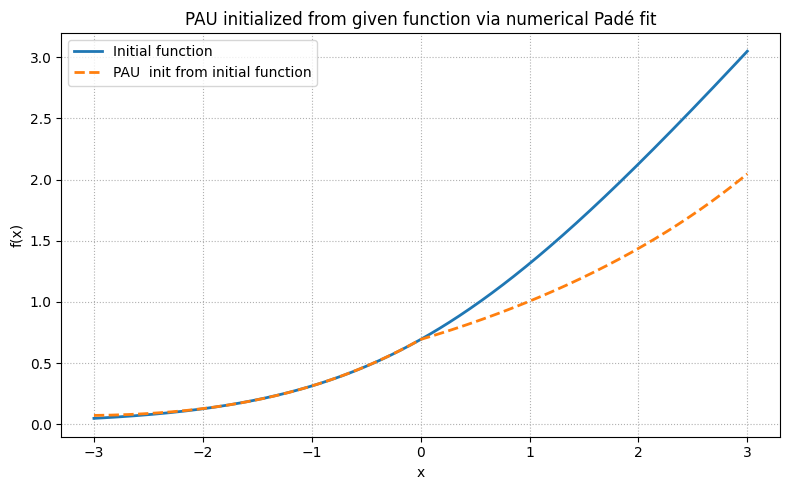

In [88]:
def test_PAU_initialization(n=5,m=4, init_func=torch.nn.Softplus()):
    act = PAU(n_numerator=n, n_denominator=m, init_func=init_func)

    x = torch.linspace(-3, 3, 600, dtype=torch.float32)
    with torch.no_grad():
        y_true = init_func(x)
        y_pau  = act(x)

    x_np = x.cpu().numpy()
    plt.figure(figsize=(8, 5))
    plt.plot(x_np, y_true.cpu().numpy(), label="Initial function", linewidth=2)
    plt.plot(x_np, y_pau.cpu().numpy(), "--", label="PAU  init from initial function", linewidth=2)
    plt.title("PAU initialized from given function via numerical Padé fit")
    plt.xlabel("x"); plt.ylabel("f(x)")
    plt.legend(); plt.grid(True, linestyle=":")
    plt.tight_layout()
    plt.show()

test_PAU_initialization(n=2,m=2, init_func = torch.nn.Softplus())

## The average vector field (AVF) integrator for the 1D heat equation

We consider the one–dimensional heat equation
$$
u_t = u_{xx}, \qquad x \in [0,L], \quad t>0,
$$
subject to Dirichlet boundary conditions \(u(0,t)=u(L,t)=0\).



### Reformulation

The PDE can be written on the form
$$
\dot{u} = N \nabla H(u),
$$
where $N$ is a negative–definite operator and $H(u)$ is a Lyapunov function.
Two equivalent formulations exist:

1. $N_1 = -I,\quad H_1(u) = \tfrac12\int_0^L |u_x|^2\,dx,$
2. $N_2 = \partial_{xx},\quad H_2(u) = \tfrac12\int_0^L |u|^2\,dx.$

Both lead to the same evolution equation $u_t = u_{xx}$ and both energies $H_1$ and $H_2$
are decreasing.




### Semi–discrete system

After spatial discretisation on a uniform grid $x_j=j\Delta x \quad j=0,\ldots,N$ applying a central difference scheme on the laplacian, we obtain
the tridiagonal matrix

$$
A = \frac{1}{(\Delta x)^2}\operatorname{tridiag}(1,-2,1),
$$
yielding the semi–discrete system 
$$
\dot{\mathbf{u}} = A\,\mathbf{u}.
$$


The discrete Lyapunov functions are
$$
H_1(\mathbf{u}) = \tfrac12\,\mathbf{u}^\top(-A)\mathbf{u},
\qquad
H_2(\mathbf{u}) = \tfrac12\,\mathbf{u}^\top\mathbf{u}.
$$




### Average Vector Field (AVF) time discretisation

For the system $\dot{\mathbf{u}} = A\mathbf{u}$,  
the AVF scheme is
$$
\frac{\mathbf{u}^{n+1}-\mathbf{u}^n}{\Delta t}
= \int_0^1 A\!\left((1-\xi)\mathbf{u}^n + \xi \mathbf{u}^{n+1}\right)d\xi.
$$
Since $A$ is linear, the integral simplifies to
$$
\frac{\mathbf{u}^{n+1}-\mathbf{u}^n}{\Delta t}
= A\frac{\mathbf{u}^{n+1}+\mathbf{u}^n}{2},
$$
which yields the update rule 
$$
\boxed{(I - \tfrac{\Delta t}{2}A)\mathbf{u}^{n+1}
       = (I + \tfrac{\Delta t}{2}A)\mathbf{u}^n.}
$$





### Numerical setup

- Domain: $x\in[0,L]$ with $L=1$
- Grid: $N$ subintervals, $\Delta x = L/N$
- Boundary conditions: $u(0)=u(L)=0$
- Initial condition: $u(x,0)=x(1-x)$

The AVF update
$$
(I - \tfrac{\Delta t}{2}A)\mathbf{u}^{n+1}
  = (I + \tfrac{\Delta t}{2}A)\mathbf{u}^{n}
$$
is solved each step using an LU factorisation of the constant matrix $(I - \tfrac{\Delta t}{2}A)$.


In [95]:
from scipy.sparse import diags
from scipy.linalg import lu_factor, lu_solve

def create_sparse_tridiagonal(n, a = 1, b = -2, c = 1):
    diagonals = [np.full(n-1, a), np.full(n, b), np.full(n-1, c)]
    return diags(diagonals, offsets=[-1, 0, 1]).toarray()

In [103]:
def AVF(L= 1, N = 50, dt = 0.0025, T = 0.25, A = None):
    x = np.linspace(0, L, N + 1)
    dx = L / N
    N_t = int(T / dt)

    #Initial condition
    u = x*(1-x)

    #Periodic Dirichlet BCs, u(0)=u(L)=0
    u[0] = 0.0
    u[-1] = 0.0

    #Discrete Laplacian (negative definite N operator)
    if A is None:
        tridiag = create_sparse_tridiagonal(n=N-1)
        A = 1/dx**2*tridiag

    #(I - dt/2 * A) u^{n+1} = (I + dt/2 * A) u^n
    I = np.eye(N-1)
    LHS = I - 0.5 * dt * A
    RHS = I + 0.5 * dt * A

    #Precompute LU factorization for efficiency
    lu, piv = lu_factor(LHS)

    u_all = [u.copy()]
    t_all = [0.0]

    for n in range(N_t):
        u_old = u[1:-1]
        rhs = RHS @ u_old
        u_new = lu_solve((lu, piv), rhs)
        u[1:-1] = u_new

        #Save every 10th time step
        #if (n + 1) % 10 == 0:
        u_all.append(u.copy())
        t_all.append((n + 1) * dt)

    return x, np.array(t_all), np.array(u_all)

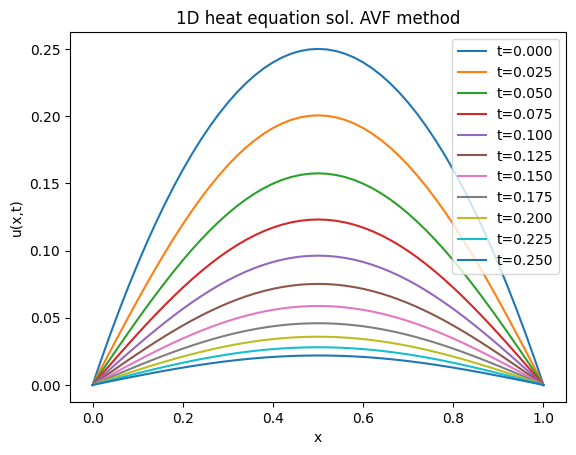

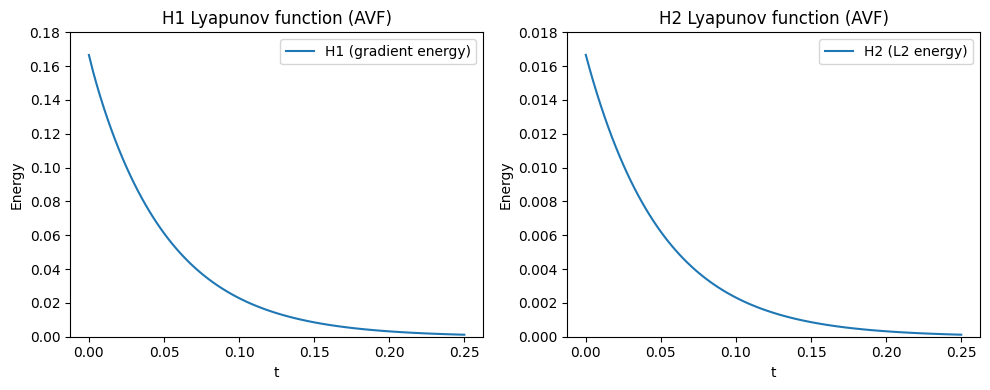

In [106]:
L=1.0
N=50
T=0.25
dt=0.0025

x, t, U = AVF(L=L, N=N, dt=dt, T=T)

plt.figure()
#Only plot every 20th time step 
for i in range(0, len(t), 10):     
    plt.plot(x, U[i], label=f"t={t[i]:.3f}")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title("1D heat equation sol. AVF method")
plt.legend()
plt.show()


dx = x[1] - x[0]
A = (1/dx**2) * create_sparse_tridiagonal(n = N-1)
H1 = [0.5 * u[1:-1].T @ (-A) @ u[1:-1] * dx for u in U]
H2 = [0.5 * np.sum(u[0:-1]**2) * dx   for u in U]


fig, axes = plt.subplots(1, 2, figsize=(10, 4))  

axes[0].plot(t, H1, label='H1 (gradient energy)')
axes[0].set_xlabel("t")
axes[0].set_ylabel("Energy")
axes[0].legend()
axes[0].set_ylim(0, 0.18)  
axes[0].set_title("H1 Lyapunov function (AVF)")

axes[1].plot(t, H2, label='H2 (L2 energy)')
axes[1].set_xlabel("t")
axes[1].set_ylabel("Energy")
axes[1].legend()
axes[1].set_ylim(0, 0.018)  
axes[1].set_title("H2 Lyapunov function (AVF)")

plt.tight_layout()
plt.show()

